# Intro
The goal of this notebook is to build an image classifier for images of building's facades (label 'Facade') or interiors (label 'Flat').

Dataset with train images is provided by Happs team (http://namr.com/data/cv/data.zip).

This was originally cloned and then update by me from https://github.com/marsbroshok/image-classifier-with-tensorflow


## Module Imports
First of all we need to import all necessary modules:

In [1]:
import os
import shutil
import numpy as np

import tensorflow as tf
# you no longer need to "from tf import keras' this is old and now we call keras from ensorflow 

from matplotlib import pyplot as plt 


from keras import backend as K
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Input, Lambda, Dense, BatchNormalization, Flatten
from keras.layers import Convolution2D, MaxPooling2D, Dropout
from keras.models import Model
from keras.optimizers import Adam, Adagrad, SGD, RMSprop
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

%matplotlib inline

Using TensorFlow backend.


## Initialize common variables
We set random seed and some shared variables

In [4]:
# Set seed
from numpy.random import seed
seed(42)
from tensorflow import set_random_seed
set_random_seed(42)

# Global variables
BATCH_SIZE = 128
TARGET_SIZE=(224, 224)  # Resize input images to that size
INPUT_SHAPE = TARGET_SIZE + (3,)
NUM_CLASSES = 2  
DATA_PATH = './data/'  # Root data path
TRAIN_PATH = os.path.join(DATA_PATH, 'train')  # Train data path 
VAL_PATH = os.path.join(DATA_PATH, 'val-custom')  # Validation data path

print("Variables set")

Vars set


## Helper functions

In [5]:
def classes_stat(image_iterator):
    """
    Function to print how many items per class has `image_iterator`.
    Returns dictionary `class_idx` to match class index to label
    """
    classes = image_iterator.classes
    class_idx = {v:k for k, v in image_iterator.class_indices.items()}
    for c in np.unique(classes):
        count = np.sum(classes==c)
        print('Class {} ({}): {} items'.format(c, class_idx[c], count))
    return class_idx

In [6]:
def image_plots(imgs, figsize=(12,8), rows=1, interp=False, titles=None):
    """
    Function to plot images from `imgs` array with optional labels from `titles`.
    Images will be plot in one figure with number of `rows`. 
    """
    f = plt.figure(figsize=figsize)
    cols = len(imgs)//rows if len(imgs) % 2 == 0 else len(imgs)//rows + 1
    for i in range(len(imgs)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=12)
        plt.imshow(imgs[i], interpolation=None if interp else 'none')

# Dataset Exploration
Let's check how many images do we have in the training dataset. Also let's plot some of the images to have an idea what kind of content is there.

## Train Dataset 

In [21]:
# Create image generator to read images from directory 
# and rescale pixel values from range [0; 255] to [0;1] 
image_gen = ImageDataGenerator(rescale=1.0/255)

#note that a class is a directory under the path.  So for this example we have 2 directories, Flat & Facade
train_iterator = image_gen.flow_from_directory(TRAIN_PATH, 
                                               batch_size=BATCH_SIZE, 
                                               target_size=TARGET_SIZE)

Found 50 images belonging to 2 classes.


In [31]:
# How many images per class? with the Directory name shown
class_idx = classes_stat(train_iterator)

Class 0 (facade): 13 items
Class 1 (flat): 37 items


Indeed we have 2 classes of images. Also it is clear that our dataset is quite small - 50 images total. That could be a challenge to train an image classifier.

To finish with data exploration, we will plot images from one batch of train dataset. 

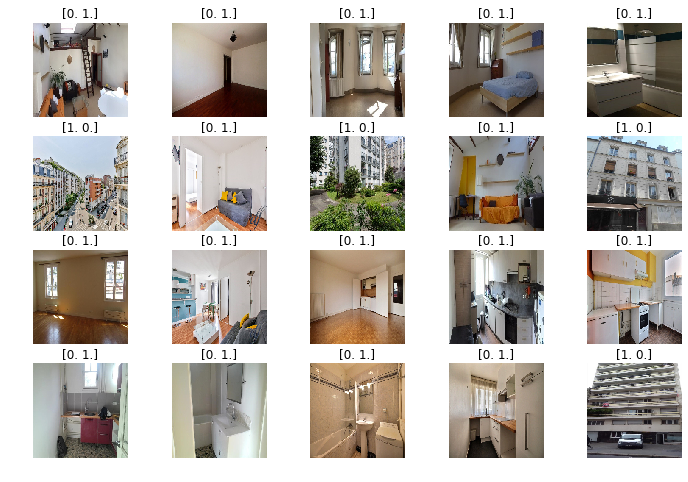

In [28]:
# Read batch of data splitting it between the 2 classes 
#bx = is the images
#by = is the directory they came from rep as an array, so 1,0 = Facade & 0,1 = Flat
bx, by = next(train_iterator)

# Show images and the directory rep
image_plots(imgs=bx[:20], titles=by[:20], rows=4)

Everything seems to be ok, we have images of interiors and facades as expected. Also we can see that image labels represented in '1-hot-encoded' form, which means that label 'Facade' has code `[1, 0]` and 'Flat' is `[0, 1]`

## Validation Dataset
In order to evaluate performance of the classifier we are building, we should use validation data. It is not appropriate to evaluate performance on the training data.
But in the original data zip file from Happs there are no validation images. 

There are some possible solutions. First of all, we can split train data into 2 subsets with ratio like 80/20 to construct validation dataset. But in our case, training data is already small and we'll need it all to perform training. 

Second option is to mine missing data ourselves, and it is that what was done. Custom validation data was copied from internet and saved to `data/val-custom` directory. It is important to remind, that we will *not use validation data* for training. Validation dataset is used only to evalute perfomance of image classifier.

In [29]:
# Create image iterator for validation set
val_iterator = image_gen.flow_from_directory(VAL_PATH, 
                                            batch_size=1, 
                                            target_size=TARGET_SIZE, 
                                            shuffle=False)


Found 105 images belonging to 2 classes.


In [32]:
# How many images per class?
class_idx = classes_stat(val_iterator)
class_idx

Class 0 (facade): 24 items
Class 1 (flat): 81 items


{0: 'facade', 1: 'flat'}

# Building Image Classifier
Our task "to classify images into 2 classes" is a classical image recognition task where the state-of-the-art solutions are Convolutional Neural Networks (CNN). 

So we will start with building VGG-like custom CNN.

## VGG-like custom CNN
Our model will have:
- 4 Convolution layers (2 layers with 64 filters, and 2 layers with 32 filters);
- Each block of Convolution layers will have one Max Pool layer;
- On the top we will put 2 Dense non-linear layers; 
- 1 Dense softmax layer to output predictions. 


*Note*: There are no strict theory on how to define hyper-parameters (how many layers-filters-etc do we need), so all parameters below are just some reasonable "start-with" values.


To build the model we will use Keras framework with Tensorflow backend.

In [13]:
# Helper to build VGG-like CNN model
def build_cnn_model():
    # Prepare input for model with custom input shape
    input_tensor = Input(shape=INPUT_SHAPE)
    
    # Conv block 64 filters
    x = Convolution2D(64, 3)(input_tensor)
    x = Convolution2D(64, 3)(x)
    x = MaxPooling2D()(x)
    
    # Conv block 32 filters
    x = Convolution2D(32, 3)(x)
    x = Convolution2D(32, 3)(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    
    # Dense block for classification
    x = Dense(32, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    pred_layer = Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)

    # Build and compile model
    model = Model(inputs=input_tensor, outputs=pred_layer)
    model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [14]:
# Create model object
model = build_cnn_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 108, 108, 32)      18464     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 106, 106, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 53, 53, 32)        0         
__________

In [15]:
# Setup variables
val_steps = val_iterator.n  # number of val images

# Train the model
model.fit_generator(train_iterator,
                    steps_per_epoch=10, 
                    epochs=3, 
                    validation_data=val_iterator, 
                    validation_steps=val_steps)

# Slow down learning rate and continue to train
# optimizer value is a float >= 0. & is the Learning rate. 
model.optimizer.lr = 1E-5 # = 0.00001 default is 0.1
model.fit_generator(train_iterator,
                    steps_per_epoch=10, 
                    epochs=5, 
                    validation_data=val_iterator, 
                    validation_steps=val_steps)

Epoch 1/3
10/10 [==============================] - 93s 9s/step - loss: 0.6437 - acc: 0.7380 - val_loss: 0.5228 - val_acc: 0.7714
Epoch 2/3
10/10 [==============================] - 85s 9s/step - loss: 0.5034 - acc: 0.7400 - val_loss: 0.5023 - val_acc: 0.7714
Epoch 3/3
10/10 [==============================] - 83s 8s/step - loss: 0.4879 - acc: 0.7400 - val_loss: 0.5279 - val_acc: 0.7714
Epoch 1/5
10/10 [==============================] - 81s 8s/step - loss: 0.4839 - acc: 0.7400 - val_loss: 0.5008 - val_acc: 0.7714
Epoch 2/5
10/10 [==============================] - 81s 8s/step - loss: 0.5376 - acc: 0.7180 - val_loss: 0.5076 - val_acc: 0.7905
Epoch 3/5
10/10 [==============================] - 85s 8s/step - loss: 0.4361 - acc: 0.8000 - val_loss: 0.5221 - val_acc: 0.7238
Epoch 4/5
10/10 [==============================] - 80s 8s/step - loss: 0.3953 - acc: 0.8400 - val_loss: 0.5179 - val_acc: 0.7238
Epoch 5/5
10/10 [==============================] - 80s 8s/step - loss: 0.3596 - acc: 0.8660 - val

Results are not very satisfying: validation loss and accuracy is stagnating around the same level. 

The fact is that our model has almost 3M parameters and only 50 training images. 

To deal with that, let's use a *"data augmentation"* trick. 

## Data Augmentation
Data augmentation is a technique to add some random transformations (like rotation or zooming) to the original images to generate the new one. Important condition is to keep images realistic enough after transformation. 

Let's change a bit image generator to add some random transformation into the images. That will allow us to "strech" our intial dataset into something bigger!

In [16]:
# Image generator with random transformations
image_trans_gen = ImageDataGenerator(rescale=1./255, 
                                     channel_shift_range=8,
                                     horizontal_flip=True,
                                     rotation_range=3, 
                                     zoom_range=(1.0, 0.7))

In [17]:
# Train image iterator with random transformations creating another 50 train images
train_iterator = image_trans_gen.flow_from_directory(TRAIN_PATH, 
                                               batch_size=BATCH_SIZE, 
                                               target_size=TARGET_SIZE)

Found 50 images belonging to 2 classes.


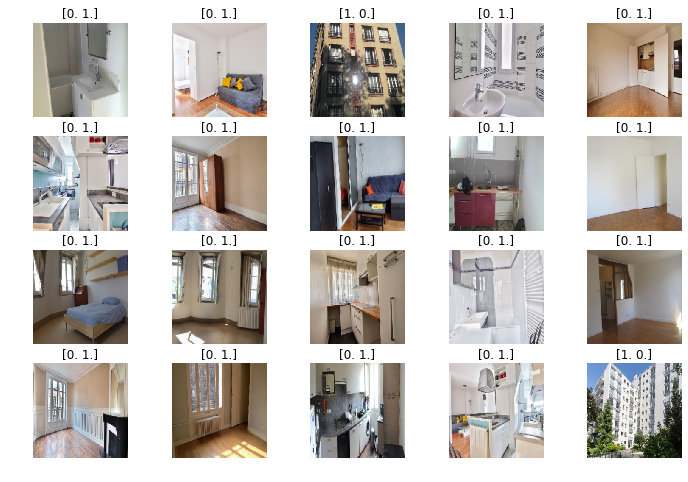

In [18]:
# Let's plot transformed images
bx, by = next(train_iterator)
image_plots(imgs=bx[:20], titles=by[:20], rows=4)

Now we can train the model again:

In [19]:
model = build_cnn_model()

# Train the model
model.fit_generator(train_iterator,
                    steps_per_epoch=10, 
                    epochs=2, 
                    validation_data=val_iterator, 
                    validation_steps=val_steps)

# Slow down learning rate and continue to train
model.optimizer.lr = 1E-5
model.fit_generator(train_iterator,
                    steps_per_epoch=10, 
                    epochs=5, 
                    validation_data=val_iterator, 
                    validation_steps=val_steps)

Epoch 1/2
10/10 [==============================] - 107s 11s/step - loss: 0.5970 - acc: 0.6920 - val_loss: 0.5260 - val_acc: 0.7714
Epoch 2/2
10/10 [==============================] - 102s 10s/step - loss: 0.5275 - acc: 0.7600 - val_loss: 0.6601 - val_acc: 0.7714
Epoch 1/5
10/10 [==============================] - 88s 9s/step - loss: 0.5151 - acc: 0.7980 - val_loss: 0.5707 - val_acc: 0.7714
Epoch 2/5
10/10 [==============================] - 125s 12s/step - loss: 0.4945 - acc: 0.8220 - val_loss: 0.7013 - val_acc: 0.7714
Epoch 3/5
10/10 [==============================] - 95s 10s/step - loss: 0.4799 - acc: 0.7900 - val_loss: 0.4453 - val_acc: 0.7905
Epoch 4/5
10/10 [==============================] - 89s 9s/step - loss: 0.4245 - acc: 0.8400 - val_loss: 0.3817 - val_acc: 0.8381
Epoch 5/5
10/10 [==============================] - 91s 9s/step - loss: 0.5796 - acc: 0.7760 - val_loss: 0.4369 - val_acc: 0.7905


Apparently, our results are better than before, but let's see if we can do better!

It could be a chance to try another helpful technique: *transfer learning*.

## Transfer Learning
Transfert learning is a method of building new neural network when we re-use pre-trained weights of other network (more details about transfert learning: https://cs231n.github.io/transfer-learning/).

In out case we will take Convolutional Neural Network VGG16 with weights pre-trained on 'Imagenet' dataset.

In 'Imagenet' there are 1000 classes, but we have 2. So we will adapt the top layers of network to produce predictions for 2 classes, and we will train only these added layers.

## Transfert Learning with VGG16 Network
Let's build adapted VGG16 model:

In [34]:
def build_vgg_ft_model():
    # Prepare input for model with custom input shape
    input_tensor = Input(shape=INPUT_SHAPE)

    # Build model with pretrained weights and not top layers
    base_model = VGG16(input_shape=INPUT_SHAPE,
                           input_tensor=input_tensor,
                           weights='imagenet',
                           include_top=False)

    # Freeze layers so training will not change its weights
    for layer in base_model.layers: layer.trainable = False

    # Add dense output with num_classes
    x = base_model.output
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dropout(0.5, name='drop')(x)
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    pred_layer = Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)

    # Build model for provided classes
    model = Model(inputs=base_model.input, outputs=pred_layer)
    model.compile(optimizer=Adam(lr=1E-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [35]:
model = build_vgg_ft_model()
model.summary()

58892288/58889256 [==============================] - 12s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_poo

In [36]:
# Train the model
model.fit_generator(train_iterator, 
                    steps_per_epoch=10, 
                    epochs=5, 
                    validation_data=val_iterator, 
                    validation_steps=val_steps)

Epoch 1/5
10/10 [==============================] - 243s 24s/step - loss: 0.4810 - acc: 0.7880 - val_loss: 0.4635 - val_acc: 0.8095
Epoch 2/5
10/10 [==============================] - 231s 23s/step - loss: 0.1383 - acc: 0.9740 - val_loss: 0.3792 - val_acc: 0.8381
Epoch 3/5
10/10 [==============================] - 228s 23s/step - loss: 0.0865 - acc: 0.9980 - val_loss: 0.3610 - val_acc: 0.8286
Epoch 4/5
10/10 [==============================] - 229s 23s/step - loss: 0.0637 - acc: 1.0000 - val_loss: 0.3595 - val_acc: 0.8381
Epoch 5/5
10/10 [==============================] - 228s 23s/step - loss: 0.0514 - acc: 1.0000 - val_loss: 0.3569 - val_acc: 0.8476


This model shows much better results! Indeed, combination of data augmentation and transfer learning allows us to train a good model with very few intial training data.

## Note on Overfitting
Sometimes model's perfomance on validation data drops after several epochs. It was the case with both custom CNN and VGG16-based CNN. 

It is a sign of overfitting, and maybe we could have added 'early stopping' to prevent model from overfitting and save training time, but due to the limit time we will not add this step.

## Save prediction results
In the end let's save trained model's weights so we can reuse it later without need to train it again.

In [37]:
# Save weights and model
model.save_weights('./vgg16ft_weights.h5')

In [38]:
# Load saved weights
model.load_weights('./vgg16ft_weights.h5')

Also let's run prediction of labels on validation dataset and save that as csv file.

In [39]:
# Predict labels for validation images
preds = model.predict_generator(val_iterator, val_steps, verbose=1)

105/105 [==============================] - 43s 412ms/step


In [45]:
# Convert predictions to classes and labels
classes = np.argmax(preds, axis=1)
labels = [class_idx[c] for c in classes]

classes


array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [46]:
# Save prediction results for each image to csv file 
results = list(zip(val_iterator.filenames, labels))

In [47]:
csv_fn = './pred_results.csv'
np.savetxt(csv_fn, results, fmt='%s,%s')

--------
2017, Alexander Usoltsev, usoltsev.av@gmail.com